# Exercise 3 Multi-class Classification 
For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9).  
This exercise will show you how the methods you've learned can be used for this
classification task.

## Dataset
There are 5000 training examples in ex3data1.mat, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. 

The 20 by 20 grid of pixels is unrolled into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X.  

To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a `0` digit is labeled as `10`, while the digits `1` to `9` are labeled as `1` to `9` in their natural order.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from pandas import DataFrame as dframe

In [2]:
# Setup the parameters you will use for this part of the exercise
input_layer_size = 400 # 20 x 20 input images of digits
num_labels = 10 # 1-10 labels (0-9)

In [3]:
# =========== Part 1: Loading and Visualizing Data =============
# We start the exercise by first loading and visualizing the dataset.
# You will be working with a dataset that contains handwritten digits.
# Load training data
data = sio.loadmat('ex3data1.mat')

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [5]:
# Storing training data to X and y
X = data['X']
y = data['y']
m = len(X)

In [6]:
X.shape, y.shape

((5000, 400), (5000, 1))

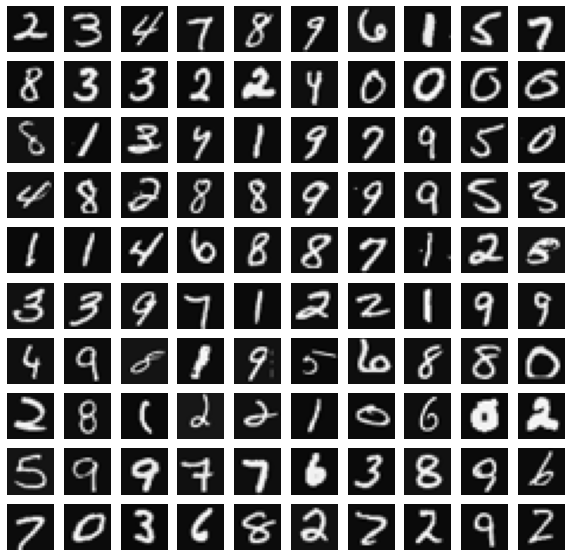

In [7]:
# Select 100 data randomly to be visualized
_, ax = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        pic = X[np.random.randint(m)].reshape([20, 20], order='F')
        ax[i,j].imshow(pic, cmap='gray')          
        ax[i,j].axis('off')

## Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a
multi-class classifer. Since there are 10 classes, you will need to train 10
separate logistic regression classifers.

To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any `for loops`

In [8]:
# Sigmoid function
def sigmoid(z):
    sig = 1/(1+np.exp(-z))
    return sig

### Vectorizing the cost function
![vect_costfunct1](./img/vect_costfunct1.png)
![vect_costfunct2](./img/vect_costfunct2.png)

In [9]:
# Later in this code, scipy.optimize.fmin_cg will be used, 
# unlike previous homework, this function requires grad descent function as its parameter
# Thus, regularized cost function and grad descent function will be defined separately as well

def regCostFunction(theta, X, y, λ):
    # Initialize some useful values
    m = X.shape[0]; # number of training examples

    # You need to return the following variables correctly 
    J = 0;
    
    # Sigmoid
    z = X@theta
    g_z = sigmoid(z)
    
    # Cost function
    J = 1/m * np.sum([(-y * np.log(g_z))-(1-y)*(np.log(1-g_z))]) + (λ/(2*m) * np.sum(theta[1:]**2))
    
    return J

### Vectorizing the gradient
![vect_grad1](./img/vect_grad1.png)
![vect_grad2](./img/vect_grad2.png)
![vect_grad3](./img/vect_grad3.png)

In [10]:
def regGradDescent(theta, X, y, λ):
    # Initialize some useful values
    m = X.shape[0]; # number of training examples

    # You need to return the following variables correctly 
    grad = np.zeros([theta.size,1]);
    
    # Sigmoiddd
    z = X@theta
    g_z = sigmoid(z)
    
    # Grad descent
    grad = 1/m * X.T @ (g_z - y);
    grad[1:] = grad[1:] + (λ/m * theta[1:])
    
    return grad

### Vectorizing regularized logistic regression
![vect_regcostgrad1](./img/vect_regcostgrad.png)

In [11]:
# LRCOSTFUNCTION Compute cost and gradient for logistic regression with regularization
# This function is copied from previous homework, it is already vectorized

def lrCostFunction(theta, X, y, λ):
    # Initialize some useful values
    m = X.shape[0]; # number of training examples

    # You need to return the following variables correctly 
    J = 0;
    grad = np.zeros([theta.size,1]);
    
    # Sigmoid
    z = X@theta
    g_z = sigmoid(z)
    
    # Cost function
    J = 1/m * np.sum([(-y * np.log(g_z))-(1-y)*(np.log(1-g_z))]) + (λ/(2*m) * np.sum(theta[1:]**2))
    
    # Grad descent
    grad = 1/m * X.T @ (g_z - y);
    grad[1:] = grad[1:] + (λ/m * theta[1:])
    
    return J, grad    

In [12]:
# ============ Part 2a: Vectorize Logistic Regression ============
# Testing lrCostFunction() with regularization
np.random.seed(12346)

theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack([np.ones([5, 1]), (np.arange(1,16)/10).reshape(5, 3, order='F')])
y_t = (np.array([1, 0, 1, 0, 1]) >= 0.5)*1

lambda_t = 3

In [13]:
print(y_t)

[1 0 1 0 1]


In [14]:
print(X_t)

[[1.  0.1 0.6 1.1]
 [1.  0.2 0.7 1.2]
 [1.  0.3 0.8 1.3]
 [1.  0.4 0.9 1.4]
 [1.  0.5 1.  1.5]]


In [15]:
[J, grad] = lrCostFunction(theta_t, X_t, y_t, lambda_t)

In [16]:
print('Cost: ', J);
print('Expected cost: 2.534819\n');
print('Gradients:');
print(grad, '\n');
print('Expected gradients:');
print(' 0.146561  -0.548558  0.724722  1.398003');

Cost:  2.534819396109744
Expected cost: 2.534819

Gradients:
[ 0.14656137 -0.54855841  0.72472227  1.39800296] 

Expected gradients:
 0.146561  -0.548558  0.724722  1.398003


## One-vs-all Classification

In [17]:
# ============ Part 2b: One-vs-All Training ============
from scipy import optimize

In [18]:
def oneVsAll(X, y, num_labels, λ):
    '''
    oneVsAll will use fmin_cg to optimize theta values
    Note that the argument passed as X should already has intercept term, shape 5000 x 401
    '''
    # Some useful variables
    (m, n) = X.shape # m = samples, n = features + bias term

    # Need to return following variables correctly
    all_theta = np.zeros([num_labels, n])
        
    # Opmizing regCostFunction by finding optimum theta values
    # Notice that in (y == i+1), '+1' is required to match the values of y which range from 1-10, python counts from 0
    # Don't forget the x0 and y has to be in 1-D
    for i in range(num_labels):
        all_theta[i] = optimize.fmin_cg(f=regCostFunction, fprime=regGradDescent, 
                                           x0=all_theta[i], 
                                           args=(X, ((y == i+1)*1).flatten(), λ), 
                                           maxiter=50)
    
    return all_theta

In [19]:
theta_opt = oneVsAll(X, y, num_labels=10, λ=0.1)

         Current function value: 0.014651
         Iterations: 50
         Function evaluations: 182
         Gradient evaluations: 182
         Current function value: 0.060195
         Iterations: 50
         Function evaluations: 148
         Gradient evaluations: 148
         Current function value: 0.073643
         Iterations: 50
         Function evaluations: 131
         Gradient evaluations: 131
         Current function value: 0.037010
         Iterations: 50
         Function evaluations: 161
         Gradient evaluations: 161
         Current function value: 0.062301
         Iterations: 50
         Function evaluations: 133
         Gradient evaluations: 133
         Current function value: 0.022540
         Iterations: 50
         Function evaluations: 172
         Gradient evaluations: 172
         Current function value: 0.034106
         Iterations: 50
         Function evaluations: 155
         Gradient evaluations: 155
         Current function value: 0.127093
      

In [20]:
dframe(theta_opt).head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,6.609171e-05,-0.000611,-0.000668,0.002823,-0.033386,-0.011041,0.000881,0.001357,...,0.044480,0.000846,0.056874,0.360047,-0.012554,-0.139746,-0.033416,0.004166,1.736150e-07,0.0
1,0.0,0.0,-5.069217e-05,0.000591,-0.000639,-0.015032,-0.012845,-0.024606,-0.002495,-0.014396,...,0.220804,0.489175,0.373755,-0.047969,0.028955,0.011931,0.016097,0.004285,-4.925449e-04,0.0
2,0.0,0.0,-1.653827e-05,-0.000158,0.004556,0.029230,-0.018312,-0.023820,-0.007579,-0.015127,...,0.013234,0.026548,0.007667,-0.004122,-0.008054,-0.003489,0.000406,-0.000028,7.123896e-07,0.0
3,0.0,0.0,-9.828307e-06,0.000038,0.001089,-0.000613,0.001548,0.077581,0.062040,0.110578,...,-0.084247,-0.223573,-0.316155,-0.019113,0.009113,-0.002544,-0.001474,0.000119,3.410337e-06,0.0
4,0.0,0.0,-8.333774e-07,0.000061,-0.000631,-0.005657,-0.003468,-0.016474,-0.008693,-0.001272,...,-0.009874,-0.083690,-0.106260,-0.021696,-0.058095,-0.010671,0.003062,-0.000241,6.690478e-07,0.0


In [21]:
def predictOneVsAll(all_theta, X):
    '''
    predictOneVsAll will predict the output of each sample and overall accuracy
    This function receives two parameters, optimized theta and X
    Note that the argument passed as X should already has intercept term, shape 5000 x 401

    '''
    # Hypothesis
    h_x = X@all_theta.T
    
    # argmax will return index of maximum value within a indicated axis
    # Likewise, '+1' is added since python indexing starts at 0
    p = np.argmax(h_x, axis=1)+1
    
    acc = (p == y.flatten())*1
    acc = (np.sum(acc)/acc.size)*100
    
    return p, acc

In [22]:
pred, acc = predictOneVsAll(theta_opt, X)

In [23]:
# Acquired accuracy may differ from MATLAB
print('Training Set Accuracy: ', acc)

Training Set Accuracy:  94.56
